In [1]:
import numpy as np
import matplotlib.pyplot as plt
from esn.esn import DeepESN, DeepSubreservoirESN
from esn import activation as A
from esn.initialization import *
from scipy.integrate import odeint
import torch
np.random.seed(42)

In [2]:
device = torch.device('cpu')
dtype = torch.double
torch.set_default_dtype(dtype)

In [3]:
!which python

/home/pawel/anaconda3/bin/python


In [4]:
def lorenz():
    """Lorenz system."""
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    def f(state, t):
        x, y, z = state  # Unpack the state vector
        return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives
    return f

In [5]:
x0 = np.array([1.0, 1.0, 1.01], dtype=np.float32) # małe zaburzenie w Z(t0)
t = np.arange(0.0, 30.0, 0.01, dtype=np.float32)

states = odeint(lorenz(), x0, t)
states.dtype
# states.shape

dtype('float64')

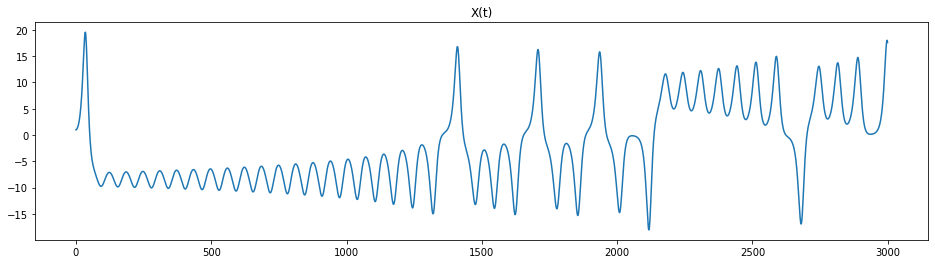

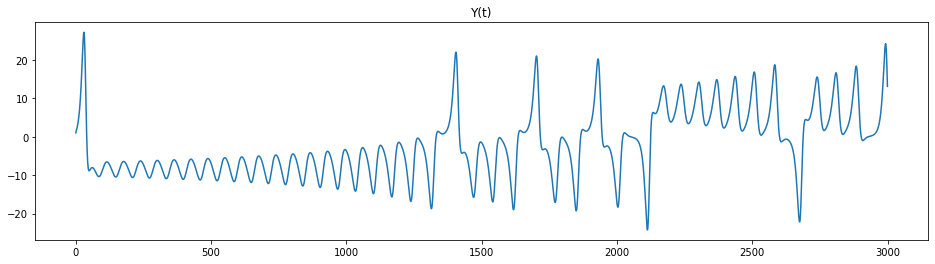

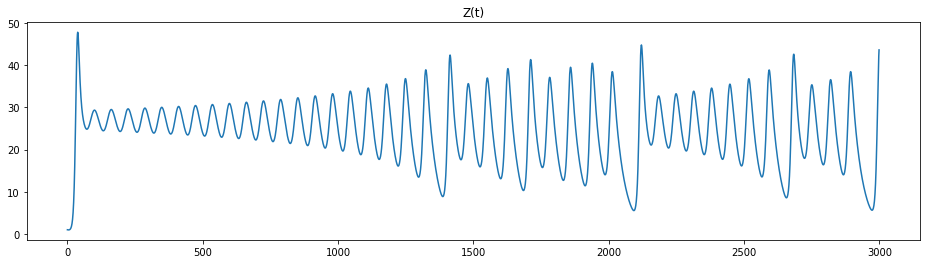

In [6]:
for i, title in [(0, 'X(t)'), (1, 'Y(t)'), (2, 'Z(t)')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(states[:, i])
    plt.show()

In [7]:
type(states) #.dtype

numpy.ndarray

In [21]:
inputLength = len(states)
trainingLength = int(350*0.5)

data = states[:350, 0]

# inputData = np.array(states[:, 0])
# outputData = np.array(states[:, 0])

# inputDataTraining = inputData[:trainingLength - 1]
# inputDataValidation = inputData[trainingLength:-1]

# outputDataTraining = outputData[1:trainingLength]
# outputDataValidation = outputData[trainingLength + 1:]

In [22]:
X = data[:-1].reshape((-1, 1, 1))
X = torch.from_numpy(X).to(device)
y = data[1:].reshape((-1, 1, 1))
y = torch.from_numpy(y).to(device)

In [23]:
X, X_test, y, y_test = X[:-trainingLength], X[-trainingLength:], y[:-trainingLength], y[-trainingLength:]

In [24]:
print(X.shape, X_test.shape, y.shape, y_test.shape)

torch.Size([174, 1, 1]) torch.Size([175, 1, 1]) torch.Size([174, 1, 1]) torch.Size([175, 1, 1])


In [25]:
X, X_test, y, y_test = X - torch.mean(X), X_test - torch.mean(X_test), y - torch.mean(y), y_test - torch.mean(y_test)
X, X_test, y, y_test = X, X_test, y, y_test

In [26]:
esn = DeepESN(1, 1000, initializer=WeightInitializer(), num_layers=3, bias=False, activation=A.tanh(leaky_rate=0.6),
              transient=365)

In [27]:
esn.fit(X, y)
pred = esn(X_test)

RuntimeError: size mismatch, m1: [3001 x 3001], m2: [0 x 1] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41

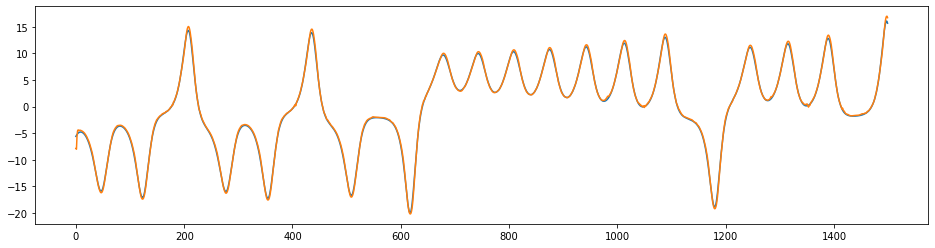

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.plot(y_test.view(-1).detach().numpy(), label='test')
ax.plot(pred.view(-1).detach().numpy(), label='prediction')
plt.show()

In [19]:
esn = DeepSubreservoirESN(1, 1, initializer=SubreservoirWeightInitializer(subreservoir_size=20), num_layers=3,
                          bias=False, activation=A.tanh(leaky_rate=0.6),
                          transient=60)

In [22]:
esn.fit(X, y)
pred = esn(X_test)

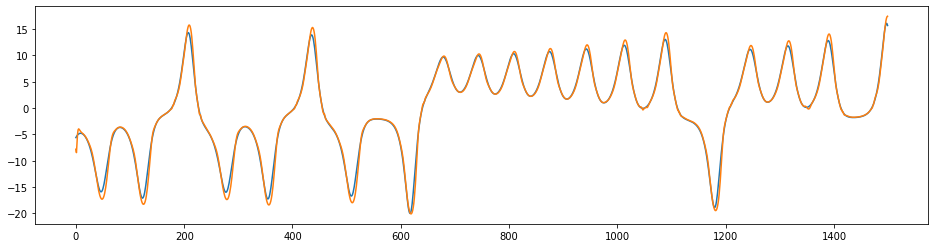

In [23]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.plot(y_test.view(-1).detach().numpy(), label='test')
ax.plot(pred.view(-1).detach().numpy(), label='prediction')
plt.show()

In [ ]:
X.shape